In [1]:
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import os
import torch
from typing import List

from dataset import CLIPDataset, get_transforms, collate_fn
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer
from tqdm import tqdm
from clip import CLIPModel  # type: ignore
from train import wandb_config

config = wandb_config['config']
device = config['device']


def get_image_embeddings(image_names: List[str], model_path):
    dataset = CLIPDataset(image_filenames=image_names, captions=None,
                          tokenizer=None, max_length=None, transforms=get_transforms(mode='test', image_size=224))
    loader = DataLoader(dataset, batch_size=32,
                        shuffle=False, collate_fn=collate_fn)

    model = CLIPModel(
        text_model_name=config['text_encoder']['model_name'],
        image_model_name=config['image_encoder']['model_name'],
        text_pretrained=config['text_encoder']['pretrained'],
        text_trainable=config['text_encoder']['trainable'],
        image_pretrained=config['image_encoder']['pretrained'],
        image_trainable=config['image_encoder']['trainable'],
        text_embedding_dim=config['text_encoder']['embedding_dim'],
        image_embedding_dim=config['image_encoder']['embedding_dim'],
        projection_dim=config['projection_head']['embedding_dim'],
        temperature=config['train']['temperature']
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(loader):
            image = batch['image'].to(device)
            image_embeddings.append(model.get_image_features(image))
    return model, torch.cat(image_embeddings)


def find_matches(model, query, image_embeddings, image_filenames, size: tuple[int, int]):
    tokenizer: DistilBertTokenizer = DistilBertTokenizer.from_pretrained(
        config['text_encoder']['model_name'])
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = model.get_text_features(
            batch['input_ids'], batch['attention_mask']
        )

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    row, col = size
    n = row * col
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches_files = [image_filenames[idx] for idx in indices]

    _, axes = plt.subplots(row, col, figsize=(15, 8))
    print('query', f'"{query}"')
    for idx, ax in zip(range(len(matches_files)), axes.flatten()):
        filename = matches_files[idx]
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ax 显示相似性得分
        ax.set_title(f'score: {values[idx]:.2f}')
        ax.imshow(image)
        ax.axis("off")

    plt.show()


def get_image_names(img_dir: str):
    return [os.path.join(img_dir, name) for name in os.listdir(img_dir) if name.endswith('.jpg') or name.endswith('.png')]

/Users/apple/Desktop/python/dh_ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_names1 = get_image_names('datasets/images/')
img_names2 = get_image_names('datasets/cars/')
img_names3 = get_image_names('datasets/child/')
img_names = img_names1 + img_names2 + img_names3
query_list = [
    'a photo of dog',
    'a photo of cat, type of animal',
    'a photo of people laugh loudly',
    'a photo of people working in the office',
    'a photo of traffic, many cars across the road',
    'a photo of child playing outside'
]

In [3]:
model, image_embeddings = get_image_embeddings(
    img_names, "./models/best_model.pth")

100%|██████████| 269/269 [00:24<00:00, 11.13it/s]


query "a photo of traffic, many cars across the road"


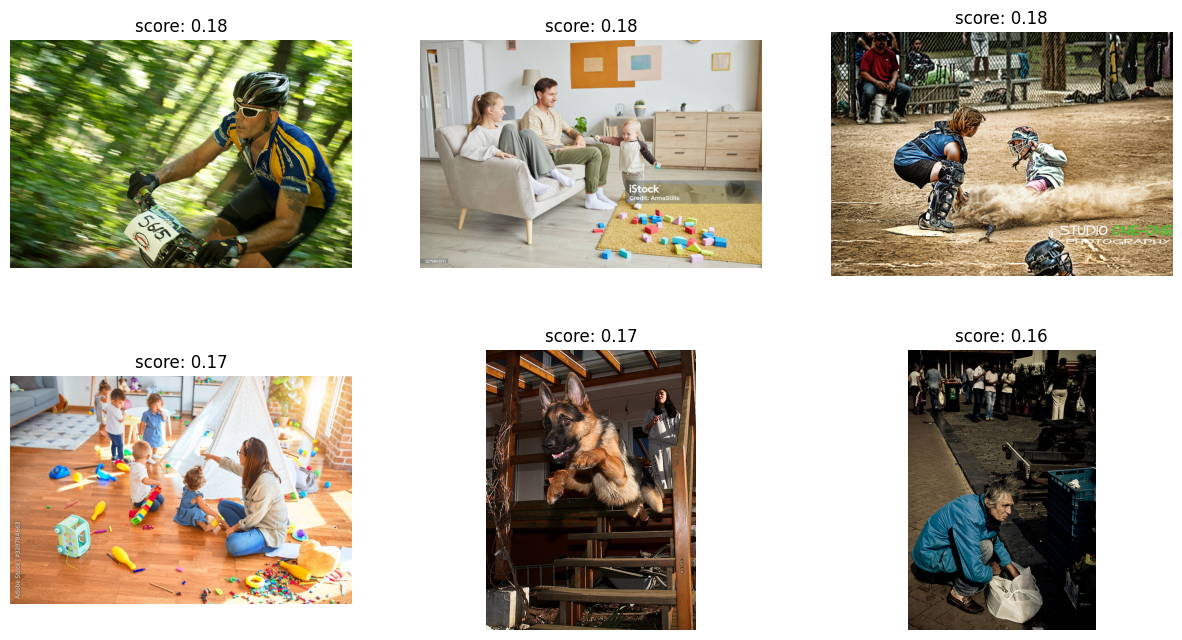

In [10]:
find_matches(model,
             query=query_list[4],
             image_embeddings=image_embeddings,
             image_filenames=img_names,
             size=(2, 3))

In [11]:
model1, image_embeddings1 = get_image_embeddings(
    img_names, "./models/预训练+微调/best_model.pth")

100%|██████████| 269/269 [00:20<00:00, 12.97it/s]


query "a photo of child playing outside"


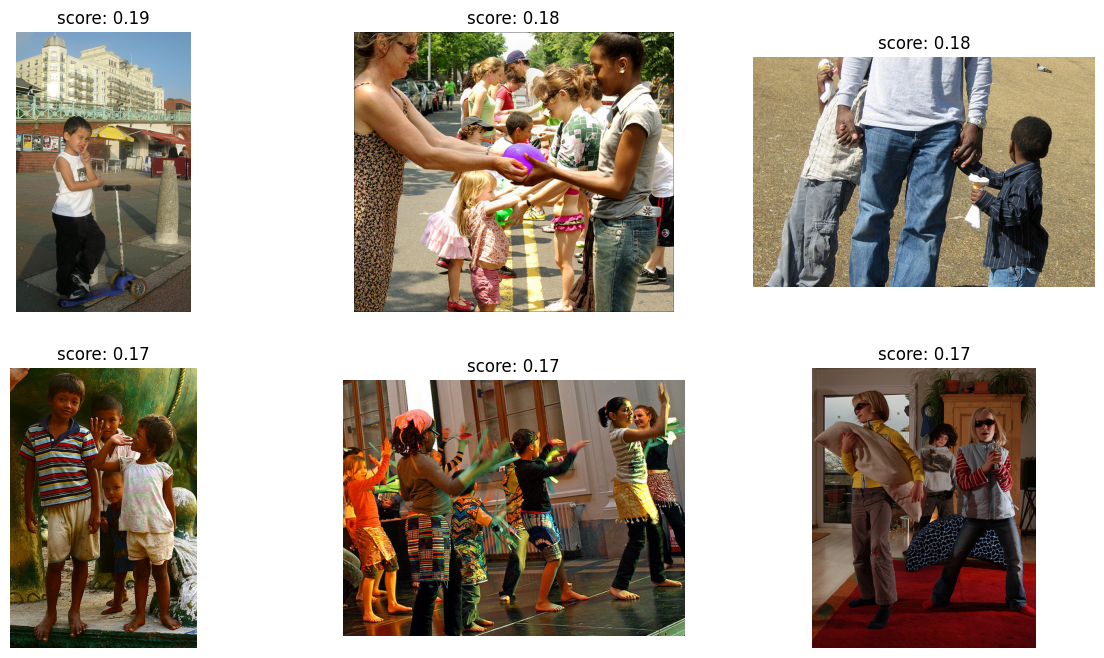

In [18]:
query_text = 'a car driving on the road'
find_matches(model1,
             query=query_list[4],
             image_embeddings=image_embeddings1,
             image_filenames=img_names,
             size=(2, 3))